#### Code review for jessicahoch


In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

/Users/chloehacker/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# fix a random seed
np.random.seed(12345)

data = pd.DataFrame({
    "years": np.arange(0, 25),
    "score": np.concatenate([
    np.random.poisson(5.0, 15),
    np.random.poisson(1.0,10),
    ])
})


missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "years"] = np.nan

In [3]:
data.head()

,score,years
0,4,0.0
1,7,1.0
2,7,NaN
3,8,3.0
4,3,4.0


In [4]:
# plot the generated data
toyplot.scatterplot(
    data.years,
    data.score, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="years", 
    ylabel="score",
);

0 5 10 15 20 25 years 0 5 10 score

In [5]:
with pm.Model?() as score_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.years.min(), 
        upper=data.years.max(), 
        testval=12)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.years, early_rate, late_rate)

    years = pm.Poisson('years', rate, observed=data.score)

In [6]:
with score_model:
    trace = pm.sample(10)

/Users/chloehacker/miniconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
 99%|█████████▉| 505/510 [00:00<00:00, 509.68it/s]/Users/chloehacker/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 510/510 [00:01<00:00, 506.94it/s]
/Users/chloehacker/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.


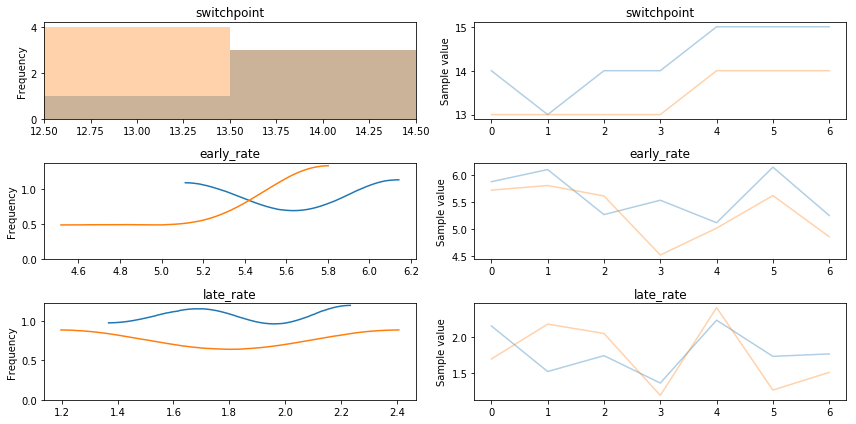

In [7]:
pm.traceplot(trace[3:]);

In [8]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,13.950000,0.864581,0.249499,13.000000,16.000000,6.0,0.951861
early_rate,5.455668,0.393160,0.086799,4.515851,6.141674,20.0,0.992838
late_rate,1.853345,0.384004,0.070354,1.197555,2.420912,20.0,0.951030


The code all ran smoothly with no errors. 

-What method did they use to generate data? What types of distributions did they sample data from? What type of data do these distributions generate?

This was the method used in notebook 10.6, generating the data and then running it through the model.

-What type of model did they try to fit with pymc3? Did they link to the tutorial that their analysis is based on. Which parameters of the model are they trying to fit.

-They are trying to estimate the switchpoint of the data. They use the early and late switch rates.

Are they sampling data in their model from the same type of distribution that was used to generate the data?

Yes, they use the poisson sampling method.

-Do you agree or disagree with their assessment of the model fit? Did it work well? How might you suggest improving the model, or further testing this type of model?

There was no assessment but I think the model worked well, the estimated switchpoint was within boundaries, leaning toward the HPD2.5 bottom.